In [2]:
# Importing Libraries
import os
import shutil
import random
!pip install split-folders
import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Define Paths for Queen Project
dataset_dir = "/content/gdrive/My Drive/Datasets/Chess_Vision"
input_folder_binary = "/content/gdrive/My Drive/Datasets/Chess_Vision_Binary_Queen_Input"
output_folder = "/content/gdrive/My Drive/Datasets/Chess_Vision_Binary_Queen"

In [8]:
# Function to Copy Files (reuse existing function)
def copy_files(src, dst):
    os.makedirs(dst, exist_ok=True)
    for file in os.listdir(src):
        shutil.copy(os.path.join(src, file), dst)

# Prepare Dataset for Queen
non_queen_dir = os.path.join(dataset_dir, "Non_Queen")
if not os.path.exists(non_queen_dir):
    os.makedirs(non_queen_dir)

other_pieces = ["Rook", "Bishop", "Knight", "King", "Pawn"]
num_images_per_class = 19

# Copy images for Non_Queen class
if len(os.listdir(non_queen_dir)) < 110:
    for piece in other_pieces:
        piece_dir = os.path.join(dataset_dir, piece)
        images = random.sample(os.listdir(piece_dir), num_images_per_class)
        for img in images:
            shutil.copy(os.path.join(piece_dir, img), os.path.join(non_queen_dir, f"{piece}_{img}"))

In [9]:
# Count Images for Queen
queen_count = len(os.listdir(os.path.join(dataset_dir, "Queen")))
non_queen_count = len(os.listdir(non_queen_dir))
print(f"Number of Queen images: {queen_count}")
print(f"Number of Non_Queen images: {non_queen_count}")

Number of Queen images: 78
Number of Non_Queen images: 90


In [10]:
# Prepare Input Directory for Binary Classification
os.makedirs(input_folder_binary, exist_ok=True)
copy_files(os.path.join(dataset_dir, "Queen"), os.path.join(input_folder_binary, "Queen"))
copy_files(non_queen_dir, os.path.join(input_folder_binary, "Non_Queen"))

# Split Dataset
splitfolders.ratio(input_folder_binary, output=output_folder, seed=42, ratio=(.7, .2, .1))

Copying files: 168 files [00:01, 88.29 files/s]


In [11]:
# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation and test sets

# Load images from directory and apply transformations
train_generator = train_datagen.flow_from_directory(
    os.path.join(output_folder, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_folder, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_folder, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)


Found 114 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Found 19 images belonging to 2 classes.


In [12]:
# Load VGG16 model without the top layer
base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze the base model layers

# Define the input layer
inputs = Input(shape=(224, 224, 3))

# Pass the image through the base model
x = base_model(inputs, training=False)

# Flatten the output of the base model
x = Flatten()(x)

# Additional layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)  # Updated dropout rate

# Output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
binary_model = Model(inputs, outputs)

# Compile the model
binary_model.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Updated learning rate
                     metrics=["accuracy"])


58889256/58889256 [==============================] - 0s 0us/step


In [13]:
# Callbacks (modify for Queen model saving)
model_checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Datasets/queen_detector_best_model.h5', save_best_only=True,
                                   monitor='val_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [14]:
epochs = 10
batch_size = 32

history = binary_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[model_checkpoint, reduce_lr, early_stopping]
)


Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 0.8568 - accuracy: 0.4737 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 100s 24s/step - loss: 0.8568 - accuracy: 0.4737 - val_loss: 0.8173 - val_accuracy: 0.4688 - lr: 1.0000e-04
Epoch 2/10
4/4 [==============================] - 96s 25s/step - loss: 0.8293 - accuracy: 0.5263 - val_loss: 0.7807 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/10
4/4 [==============================] - 104s 25s/step - loss: 0.6353 - accuracy: 0.6404 - val_loss: 0.8454 - val_accuracy: 0.5312 - lr: 1.0000e-04
Epoch 4/10
4/4 [==============================] - 99s 26s/step - loss: 0.5601 - accuracy: 0.7368 - val_loss: 0.6314 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 5/10
4/4 [==============================] - 97s 25s/step - loss: 0.4577 - accuracy: 0.8070 - val_loss: 0.6692 - val_accuracy: 0.7188 - lr: 1.0000e-04
Epoch 6/10
4/4 [==============================] - 97s 25s/step - loss: 0.4349 - accuracy: 0.8158 - val_loss: 0.6818 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 7/10
4/4 [==============================] - 101s 25s/step - loss: 0

1/1 [==============================] - 13s 13s/step - loss: 0.5077 - accuracy: 0.7895
Test Accuracy: 78.95%
1/1 [==============================] - 11s 11s/step
              precision    recall  f1-score   support

   Non_Queen       0.88      0.70      0.78        10
       Queen       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



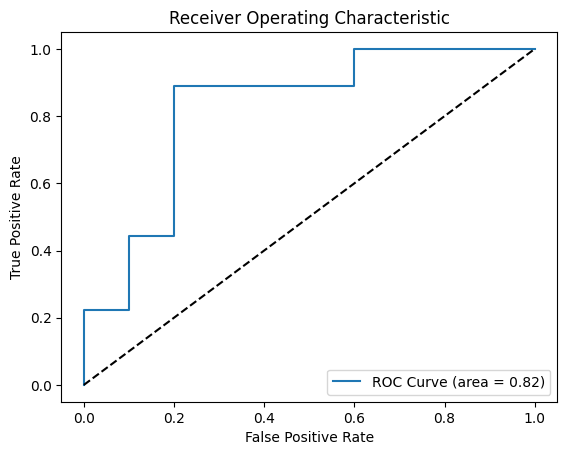

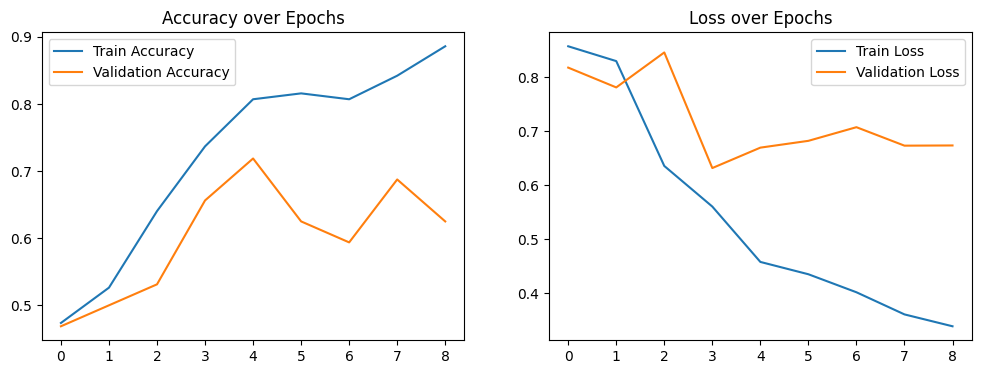

In [15]:
# Evaluate the Model
test_loss, test_accuracy = binary_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate Predictions and Evaluate
probabilities = binary_model.predict(test_generator)
predictions = [1 if x > 0.5 else 0 for x in probabilities.ravel()]
true_classes = test_generator.classes
report = classification_report(true_classes, predictions, target_names=['Non_Queen', 'Queen'])
print(report)

# ROC-AUC Score and Curve
roc_auc = roc_auc_score(true_classes, probabilities)
fpr, tpr, thresholds = roc_curve(true_classes, probabilities)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()